### Quick intro: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

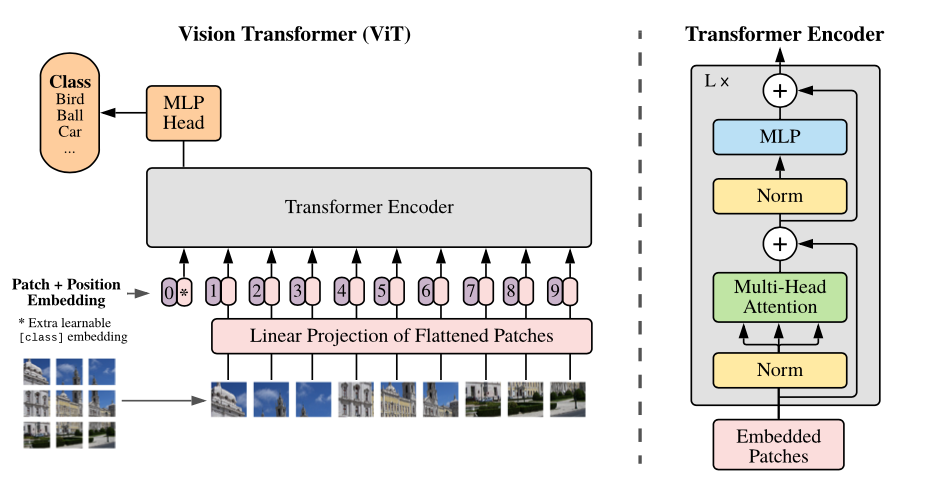

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


## Loading the data

Load topex-synth data

In [3]:
from datasets import load_dataset
# load a local dataset from image directory (huggingface)
# https://huggingface.co/docs/datasets/image_datasetRR
DATASET_TRAIN_DIR = f'data/{DATASET_TRAIN_NAME}'

train_ds = load_dataset("imagefolder", data_dir=DATASET_TRAIN_DIR, split="train")
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Resolving data files:   0%|          | 0/5088 [00:00<?, ?it/s]

Using custom data configuration default-0505dd7e3047a2ad
Found cached dataset imagefolder (/home/dennis/.cache/huggingface/datasets/imagefolder/default-0505dd7e3047a2ad/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Load topex-real data (only classes contained in train set)

In [4]:
DATASET_TEST_NAME = 'topex-real-123_pb_256'
DATASET_TEST_DIR = f'data/{DATASET_TEST_NAME}'

test_ds = load_dataset("imagefolder", data_dir=DATASET_TEST_DIR, split="test")
# We use train_test_split function to get val and test sets
# splits = test_ds.train_test_split(test_size=0.9, stratify_by_column='label')
# val_ds = splits['train']
# test_ds = splits['test']




Resolving data files:   0%|          | 0/6146 [00:00<?, ?it/s]

Using custom data configuration default-26068d303f0972f6
Found cached dataset imagefolder (/home/dennis/.cache/huggingface/datasets/imagefolder/default-26068d303f0972f6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Map id2label and label2id

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
display(id2label)

{0: '03011-205',
 1: '03026-206',
 2: '03059-08',
 3: '03288-05x20',
 4: '1015_du',
 5: '3054-12.02.17.4',
 6: '3054-12.06.07.3',
 7: '3054-12.06.08.3',
 8: '3054-12.06.14.4',
 9: '3054-12.06.19.4',
 10: '3054-12.06.30.3',
 11: '3054-12.07.16.4',
 12: '3054-12.11.01.4',
 13: '3054-12.21.01.4',
 14: '3054-12.22.03.3',
 15: '3054-12.22.04.3',
 16: '3054-12.25.03.3',
 17: '3054-12.25.04.3',
 18: '3054-12.25.06.4',
 19: '3054-12.27.03.3',
 20: '3054-12.27.05.3',
 21: '3054-12.33.01.4',
 22: '3054-12.33.08.4',
 23: '3108-12.01.05.3',
 24: '3108-12.01.15.4',
 25: '3108-12.04.03.4',
 26: '3108-12.06.04.4',
 27: '3108-12.06.06.4',
 28: '3108-12.06.12.4',
 29: '3108-12.06.18.4',
 30: '3108-12.08.10.4',
 31: '3108-12.09.03.4',
 32: '3108-12.13.11.4',
 33: '3108-12.13.14.4',
 34: '3108-12.29.01.3',
 35: '3108-12.33.01.4',
 36: '3108-12.33.04.3',
 37: '3108-12.35.00.4',
 38: '414768_30',
 39: '418mm_d4_-_montiert_v1',
 40: '6000-2rsr',
 41: '6002-2rs1',
 42: '6003-2rs1',
 43: '610_404_00',
 44: '6

Dataset({
    features: ['image', 'label'],
    num_rows: 4579
})

#labels: 159


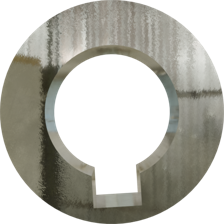

label id: 132
label name: fwssm-d25-v15-t10-kc


In [6]:
# Dataset summary
display(train_ds)
# Detailed Features
# display(train_ds.features)
# Numer of labels
print(f'#labels: {len(train_ds.features["label"].names)}')
# Example Image
display(train_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {train_ds[0]["label"]}')
print(f'label name: {id2label[train_ds[0]["label"]]}')

Display some val dataset information

Dataset({
    features: ['image', 'label'],
    num_rows: 509
})

#labels: 159


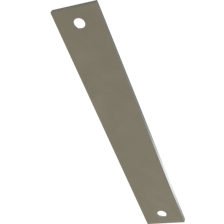

label id: 5
label name: 3054-12.02.17.4


In [7]:
# Dataset summary
display(val_ds)
# Detailed Features
# display(test_ds.features)
# Numer of labels
print(f'#labels: {len(val_ds.features["label"].names)}')
# Example Image
display(val_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {val_ds[0]["label"]}')
print(f'label name: {id2label[val_ds[0]["label"]]}')

Display some test dataset information

Dataset({
    features: ['image', 'label'],
    num_rows: 6146
})

#labels: 102


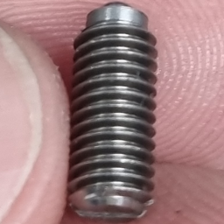

label id: 0
label name: 03011-205


In [8]:
# Dataset summary
display(test_ds)
# Detailed Features
# display(test_ds.features)
# Numer of labels
print(f'#labels: {len(test_ds.features["label"].names)}')

# Example Image
display(test_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {test_ds[0]["label"]}')
print(f'label name: {id2label[test_ds[0]["label"]]}')

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`. 

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). The transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time. 

In [9]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [10]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            Resize(feature_extractor.size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Apply the transforms to our images

In [11]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

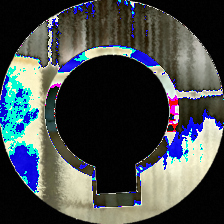

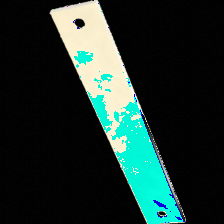

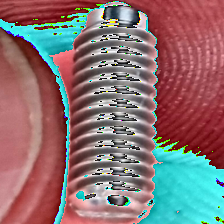

In [12]:
from PIL import Image
import torchvision.transforms as transforms
sample = transforms.ToPILImage()(train_ds[0]["pixel_values"])
display(sample)
sample = transforms.ToPILImage()(val_ds[0]["pixel_values"])
display(sample)
sample = transforms.ToPILImage()(test_ds[0]["pixel_values"])
display(sample)


In [13]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


## Define the model

Here we define the model. We define a `ViTForImageClassification`, which places a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) on top of a pre-trained `ViTModel`. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. 

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. Info [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

We also specify the number of output neurons. We set the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as `model.config`).

In [14]:
from transformers import ViTForImageClassification

num_labels = len(id2label.keys())
def model_init():
    return ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                    num_labels=num_labels,
                                                    id2label=id2label,
                                                    label2id=label2id)
model = model_init()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [16]:
# method
sweep_config = {
    'method': 'random'
}


# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 20
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict


In [18]:
import wandb

WANDB_NOTEBOOK_NAME = "synthnet_vit_hyperparameter_search.ipynb"
sweep_id = wandb.sweep(sweep_config, project='synthnet')

Create sweep with ID: zos3xt92
Sweep URL: https://wandb.ai/dritter/synthnet/sweeps/zos3xt92


In [19]:
from transformers import TrainingArguments, Trainer

def train(config=None):
  with wandb.init(config=config):
    # set sweep configuration
    config = wandb.config


    # set training arguments
    training_args = TrainingArguments(
        output_dir='vit-sweeps',
	    report_to='wandb',  # Turn on Weights & Biases logging
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
        fp16=True
    )


    # define training loop
    trainer = Trainer(
        model,
        training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        tokenizer=feature_extractor,
    )


    # start training loop
    trainer.train()


In [20]:
import wandb

wandb.agent(sweep_id, train, count=3)

wandb: Agent Starting Run: rrnu321e with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.00015311179515959224
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dritter. Use `wandb login --relogin` to force relogin


Using cuda_amp half precision backend
/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4579
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 36
  Number of trainable parameters = 85920927
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


  0%|          | 0/36 [00:00<?, ?it/s]

/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 509
  Batch size = 32


{'loss': 4.8346, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to vit-sweeps/checkpoint-36
Configuration saved in vit-sweeps/checkpoint-36/config.json


{'eval_loss': 4.665211200714111, 'eval_accuracy': 0.3104125736738703, 'eval_runtime': 4.8838, 'eval_samples_per_second': 104.222, 'eval_steps_per_second': 3.276, 'epoch': 1.0}


Model weights saved in vit-sweeps/checkpoint-36/pytorch_model.bin
Feature extractor saved in vit-sweeps/checkpoint-36/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from vit-sweeps/checkpoint-36 (score: 4.665211200714111).


{'train_runtime': 60.4345, 'train_samples_per_second': 75.768, 'train_steps_per_second': 0.596, 'train_loss': 4.8345692952473955, 'epoch': 1.0}


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: lwhd1xmq with config:
wandb: 	batch_size: 8
wandb: 	epochs: 1
wandb: 	learning_rate: 0.00011698274994489132
wandb: 	weight_decay: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
Using cuda_amp half precision backend
/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4579
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 287
  Number of trainable parameters = 85920927
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


  0%|          | 0/287 [00:00<?, ?it/s]

/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 509
  Batch size = 32


{'loss': 4.0307, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to vit-sweeps/checkpoint-287
Configuration saved in vit-sweeps/checkpoint-287/config.json


{'eval_loss': 3.655913829803467, 'eval_accuracy': 0.6227897838899804, 'eval_runtime': 4.9403, 'eval_samples_per_second': 103.03, 'eval_steps_per_second': 3.239, 'epoch': 1.0}


Model weights saved in vit-sweeps/checkpoint-287/pytorch_model.bin
Feature extractor saved in vit-sweeps/checkpoint-287/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from vit-sweeps/checkpoint-287 (score: 3.655913829803467).


{'train_runtime': 73.7618, 'train_samples_per_second': 62.078, 'train_steps_per_second': 3.891, 'train_loss': 4.0306974936030056, 'epoch': 1.0}


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: 0duthu8g with config:
wandb: 	batch_size: 64
wandb: 	epochs: 1
wandb: 	learning_rate: 0.0004950401096805455
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
Using cuda_amp half precision backend
/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4579
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 36
  Number of trainable parameters = 85920927
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


  0%|          | 0/36 [00:00<?, ?it/s]

/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 509
  Batch size = 32


{'loss': 3.1996, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to vit-sweeps/checkpoint-36
Configuration saved in vit-sweeps/checkpoint-36/config.json


{'eval_loss': 2.837934732437134, 'eval_accuracy': 0.6699410609037328, 'eval_runtime': 4.6824, 'eval_samples_per_second': 108.706, 'eval_steps_per_second': 3.417, 'epoch': 1.0}


Model weights saved in vit-sweeps/checkpoint-36/pytorch_model.bin
Feature extractor saved in vit-sweeps/checkpoint-36/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from vit-sweeps/checkpoint-36 (score: 2.837934732437134).


{'train_runtime': 55.2797, 'train_samples_per_second': 82.833, 'train_steps_per_second': 0.651, 'train_loss': 3.1995620727539062, 'epoch': 1.0}


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁
train/global_step,▁▁▁
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁


## Evaluation

Finally, let's evaluate the model on the test set: